In [1]:
import numpy as np
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Reshape, Dropout, UpSampling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt

Dataset Load

We download MNIST dataset, consisting of 60.000 images of 28x28 pixels resolution. Each image defines a handwritten number in greyscale

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


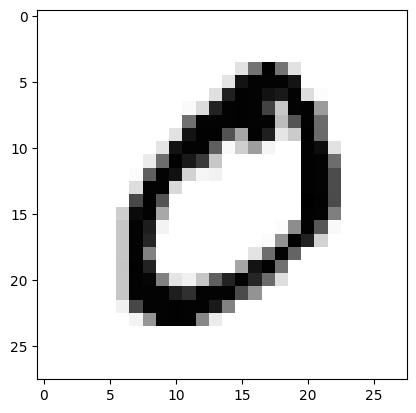

In [3]:
(X_train,Y_train), (X_test,Y_test) = mnist.load_data()
plt.imshow(X_train[1],cmap = 'Greys')
print(X_train.shape)

Preprocessing Data

In [4]:
X_train = X_train/127.5 -1

In [5]:
X_train = np.expand_dims(X_train, axis =3)

In [6]:
def create_generator():
  input = Input(shape=(100))

  x = Dense(64, activation = 'relu')(input)
  x = Dense(128, activation = 'relu')(x)
  x = Dense(512, activation = 'relu')(x)

  x = Dense(28*28, activation='tanh')(x)
  output = Reshape((28,28,1))(x)

  generator = Model(input,output)
  return generator

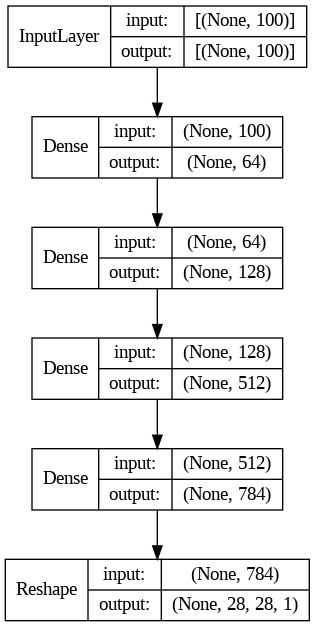

In [7]:
generator = create_generator()
plot_model(generator, show_shapes=True,show_layer_names=False)

In [8]:
from tensorflow.keras.regularizers import l1

In [9]:
def create_discriminator():
  input = Input(shape=(28,28,1))

  x = Flatten()(input)

  x = Dense(512, activation = 'relu')(x)
  x = Dense(128, activation = 'relu')(x)
  x = Dense(64, activation = 'relu')(x)

  output = Dense(1,activation = 'sigmoid')(x)


  discriminator = Model(input,output)
  return discriminator

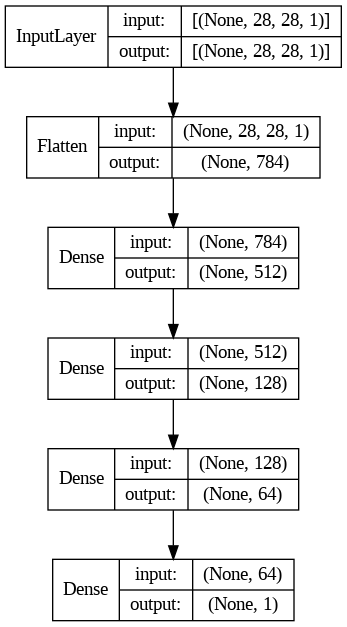

In [10]:
discriminator = create_discriminator()
plot_model(discriminator, show_shapes=True,show_layer_names=False)

GAN model definition

In [11]:
discriminator.compile(loss = 'binary_crossentropy', metrics=['accuracy'])
# discriminator.trainable = False

z = Input(shape=(100,))
img = generator(z)
validity = discriminator(img)

combined = Model(z,validity)
combined.compile(loss='binary_crossentropy')

Training

In [12]:
#Lista que acumula la funcion de perdida para luego plotearla
generator_loss =[]
discriminator_loss = []

In [13]:
def  train(X_train, generator, discriminator, combined,epochs, batch_size=32,sample_interval=100):
  valid = np.ones((batch_size,1))
  fake = np.ones((batch_size,1))

  for epoch in range(epochs):
    print("Epoch: ", epoch)

    for batch in range(int(len(X_train)/batch_size)):
      #Entreno del discriminador
      noise = np.random.normal(0,1,(batch_size,100))
      gen_imgs = generator.predict(noise)
      imgs = X_train[batch*batch_size : (batch+1)*batch_size]

      d_loss_real = discriminator.train_on_batch(imgs, valid)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, valid)

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      #Entreno del generador
      noise = np.random.normal(0,1,(batch_size,100))
      g_loss = combined.train_on_batch(noise,valid)

      if batch%50 == 0:
        print("D loss: ",d_loss[0])
        generator_loss.append(d_loss[0])
        print("D accuracy: ",d_loss[1])
        print("G loss: ",g_loss)
        discriminator_loss.append(g_loss)
        print("\n")

      if batch%sample_interval==0:
        sample_images(gen_imgs,imgs)



Plotting Functions

In [14]:
def sample_images(gen_imgs,imgs):
  plt.rcParams['figure.figsize'] = [15,5]
  fig,axs = plt.subplots(2,5)
  for i in range(5):
    axs[0,i].imshow(gen_imgs[i,:,:,0],cmap="Greys")
    axs[0,i].axis("off")

  for i in range(5):
    axs[1,i].imshow(imgs[i,:,:,0],cmap="Greys")
    axs[1,i].axis("off")
  plt.show()
  plt.close()


In [15]:
# from tensorflow.keras import regularizers, models,layers
# # Definición del modelo del discriminador
# discriminator = models.Sequential([
#     # Capas del discriminador...
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     # Más capas del discriminador...
# ])

Epoch:  0
1/1 [==============================] - 0s 20ms/step
D loss:  1.9780267024316345e-07
D accuracy:  1.0
G loss:  1.3950028687759186e-07




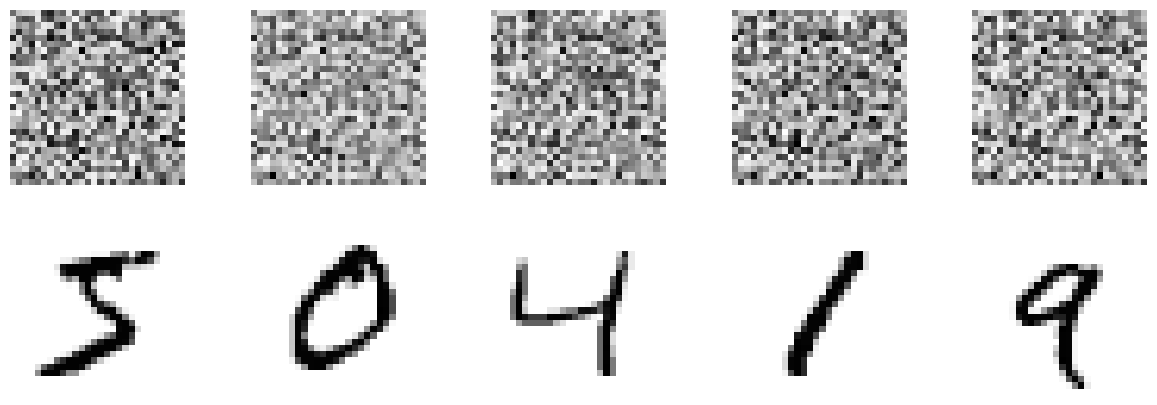

1/1 [==============================] - 0s 16ms/step
D loss:  1.2980775565551994e-07
D accuracy:  1.0
G loss:  1.1715034275994185e-07


1/1 [==============================] - 0s 26ms/step
D loss:  2.8383022376843314e-08
D accuracy:  1.0
G loss:  1.3338114968064474e-06




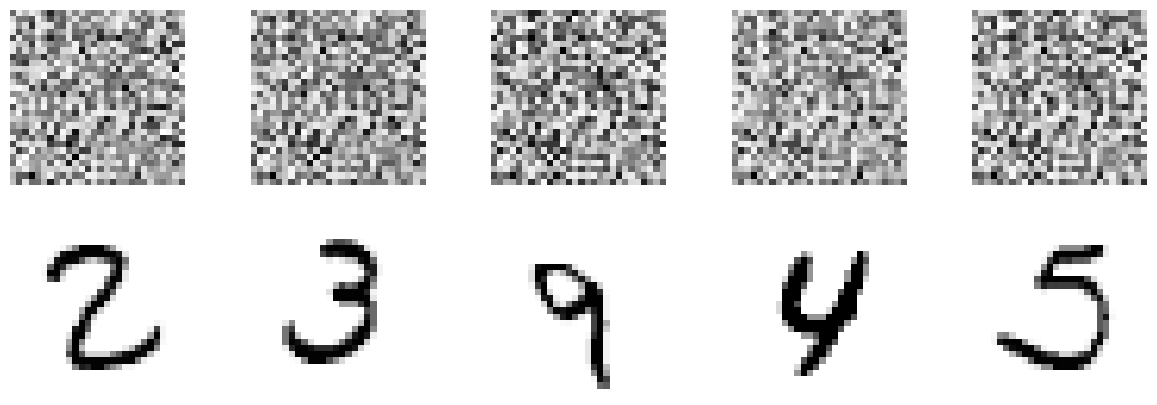

1/1 [==============================] - 0s 15ms/step
D loss:  1.349738223410668e-07
D accuracy:  1.0
G loss:  4.51076658691818e-07


1/1 [==============================] - 0s 15ms/step
D loss:  5.4478154432047177e-08
D accuracy:  1.0
G loss:  1.1565020230364098e-07




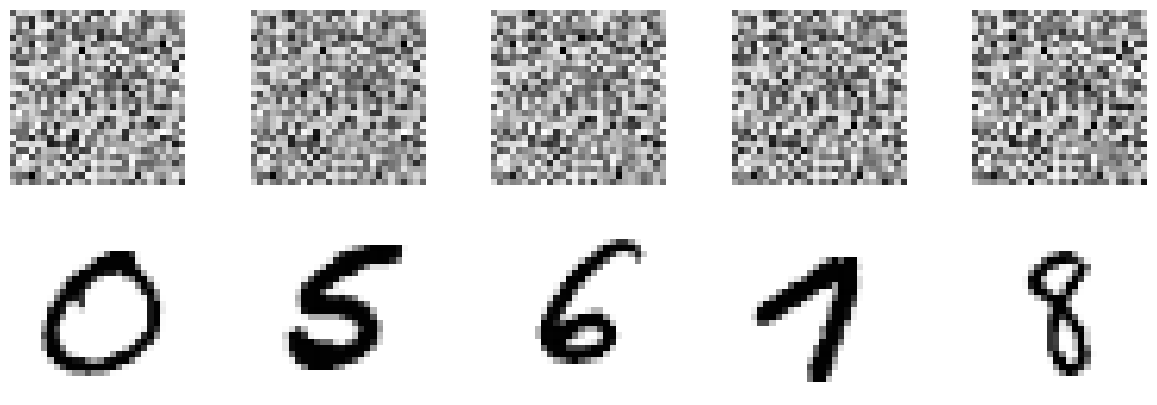

1/1 [==============================] - 0s 14ms/step


KeyboardInterrupt: ignored

In [17]:
train(X_train, generator, discriminator, combined, epochs=10, batch_size=32, sample_interval=100)

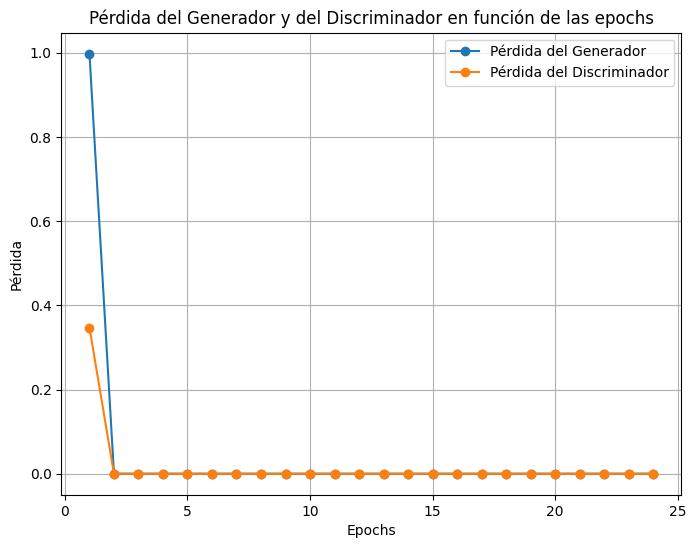

In [18]:
import matplotlib.pyplot as plt

# Crear una lista de epochs
epochs = list(range(1, len(generator_loss) + 1))  # Suponemos que el número de epochs es el mismo para ambas pérdidas

# Graficar la pérdida del generador y del discriminador en función de las epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, generator_loss, label='Pérdida del Generador', marker='o', linestyle='-')
plt.plot(epochs, discriminator_loss, label='Pérdida del Discriminador', marker='o', linestyle='-')
plt.title('Pérdida del Generador y del Discriminador en función de las epochs')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

En esta grafica se puede observar que las funciones de perdida tanto del discriminador como del generador no se consiguen mantener estables esto se debe a que la precision del discriminador es del 100% y produce que no se puedan sincronizar las dos redes haciendo asi, que la red generadora no avance.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Primer Regularizador: kernel_regularizer = l1

In [19]:
#Lista que acumula la funcion de perdida para luego plotearla
generator_loss_2 =[]
discriminator_loss_2= []

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU



In [21]:
def create_discriminator():
  input = Input(shape=(28,28,1))

  x = Flatten()(input)

  x = Dense(512, activation = 'relu',kernel_regularizer=l1(0.01))(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dense(128, activation = 'relu',kernel_regularizer=l1(0.01))(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dense(64, activation = 'relu',kernel_regularizer=l1(0.01))(x)
  x = LeakyReLU(alpha=0.2)(x)



  output = Dense(1,activation = 'sigmoid')(x)


  discriminator = Model(input,output)
  return discriminator

###---------------###########-------------------###

###---------------###########-------------------###
discriminator = create_discriminator()

plot_model(discriminator, show_shapes=True,show_layer_names=False)
###---------------###########-------------------###
# Compilación del modelo con el optimizador Adam
optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss = 'binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])
discriminator.trainable = False

z = Input(shape=(100,))
img = generator(z)
validity = discriminator(img)

combined = Model(z,validity)
combined.compile(loss='binary_crossentropy')
###---------------###########-------------------###
def  train(X_train, generator, discriminator, combined,epochs, batch_size=32,sample_interval=100):
  valid = np.ones((batch_size,1))
  fake = np.ones((batch_size,1))

  for epoch in range(epochs):
    print("Epoch: ", epoch)

    for batch in range(int(len(X_train)/batch_size)):
      #Entreno del discriminador
      noise = np.random.normal(0,1,(batch_size,100))
      gen_imgs = generator.predict(noise)
      imgs = X_train[batch*batch_size : (batch+1)*batch_size]

      d_loss_real = discriminator.train_on_batch(imgs, valid)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, valid)

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      #Entreno del generador
      noise = np.random.normal(0,1,(batch_size,100))
      g_loss = combined.train_on_batch(noise,valid)

      if batch%50 == 0:
        print("D loss: ",d_loss[0])
        generator_loss_2.append(d_loss[0])
        print("D accuracy: ",d_loss[1])
        print("G loss: ",g_loss)
        discriminator_loss_2.append(g_loss)
        print("\n")

      if batch%sample_interval==0:
        sample_images(gen_imgs,imgs)


###---------------###########-------------------###
def sample_images(gen_imgs,imgs):
  plt.rcParams['figure.figsize'] = [15,5]
  fig,axs = plt.subplots(2,5)
  for i in range(5):
    axs[0,i].imshow(gen_imgs[i,:,:,0],cmap="Greys")
    axs[0,i].axis("off")

  for i in range(5):
    axs[1,i].imshow(imgs[i,:,:,0],cmap="Greys")
    axs[1,i].axis("off")
  plt.show()
  plt.close()
###---------------###########-------------------###


###Entrenamiento_2


Epoch:  0
1/1 [==============================] - 0s 23ms/step


D loss:  170.28714752197266
D accuracy:  0.796875
G loss:  154.43458557128906




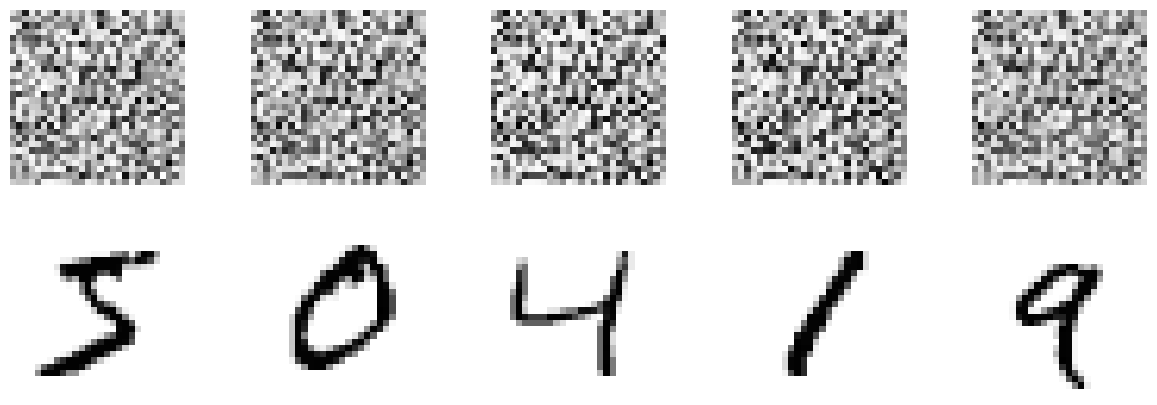

1/1 [==============================] - 0s 17ms/step
D loss:  3.747278094291687
D accuracy:  1.0
G loss:  3.6921191215515137


1/1 [==============================] - 0s 22ms/step
D loss:  2.4696468114852905
D accuracy:  1.0
G loss:  2.4665324687957764




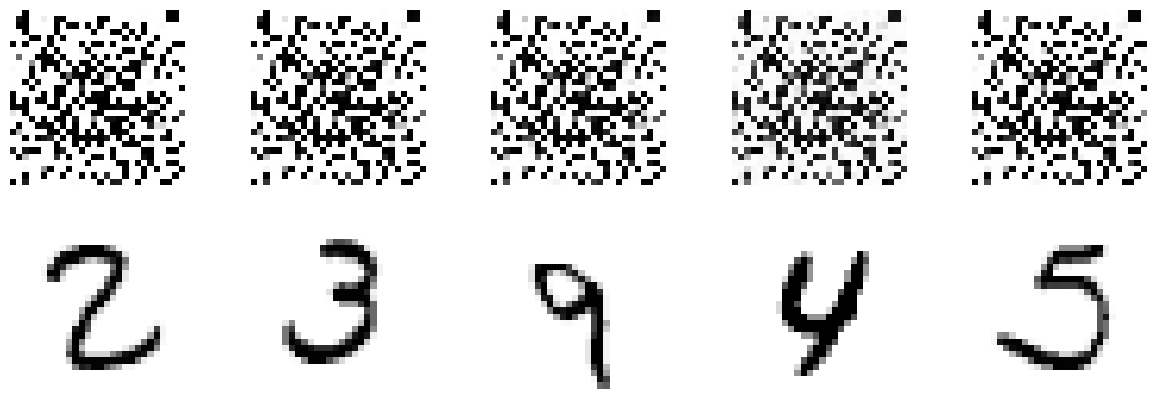

1/1 [==============================] - 0s 15ms/step
D loss:  2.3996740579605103
D accuracy:  1.0
G loss:  2.399570941925049


1/1 [==============================] - 0s 15ms/step
D loss:  2.3752323389053345
D accuracy:  1.0
G loss:  2.3759987354278564




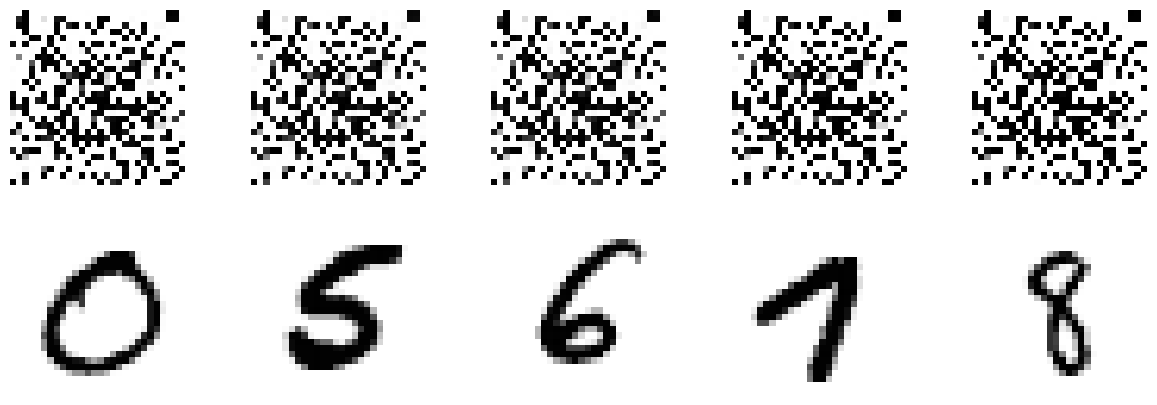

1/1 [==============================] - 0s 37ms/step
D loss:  2.369224429130554
D accuracy:  1.0
G loss:  2.3701491355895996


1/1 [==============================] - 0s 22ms/step
D loss:  2.36826491355896
D accuracy:  1.0
G loss:  2.3692760467529297




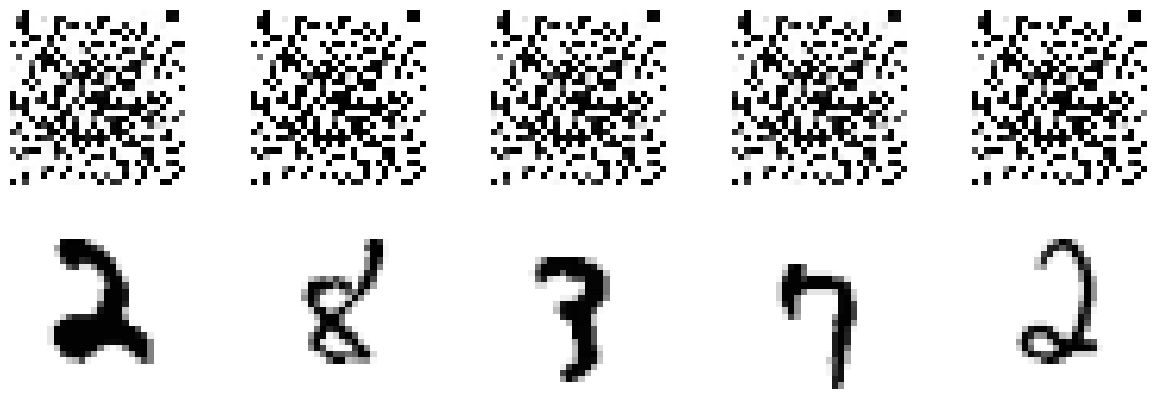

1/1 [==============================] - 0s 18ms/step
D loss:  2.3682944774627686
D accuracy:  1.0
G loss:  2.3692922592163086


1/1 [==============================] - 0s 17ms/step
D loss:  2.368282914161682
D accuracy:  1.0
G loss:  2.3692686557769775




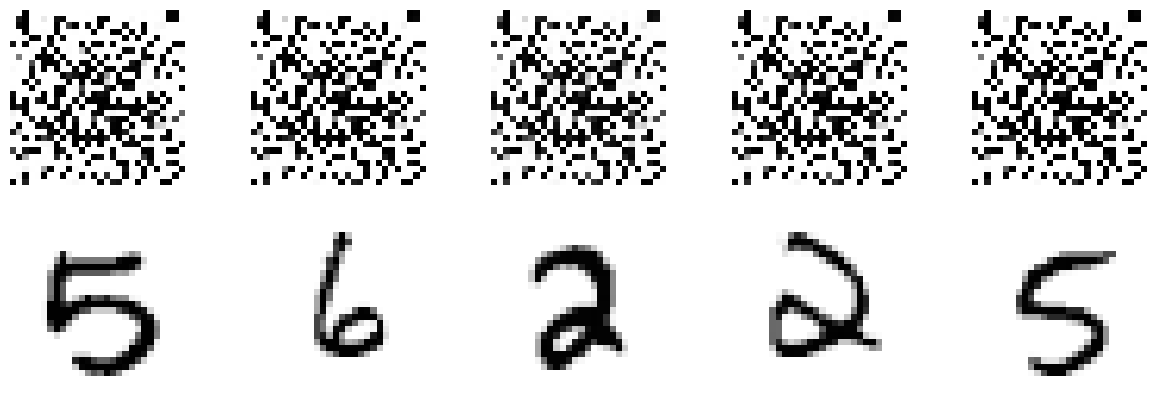

1/1 [==============================] - 0s 22ms/step
D loss:  2.3682985305786133
D accuracy:  1.0
G loss:  2.3692827224731445


1/1 [==============================] - 0s 15ms/step
D loss:  2.368289828300476
D accuracy:  1.0
G loss:  2.3692734241485596




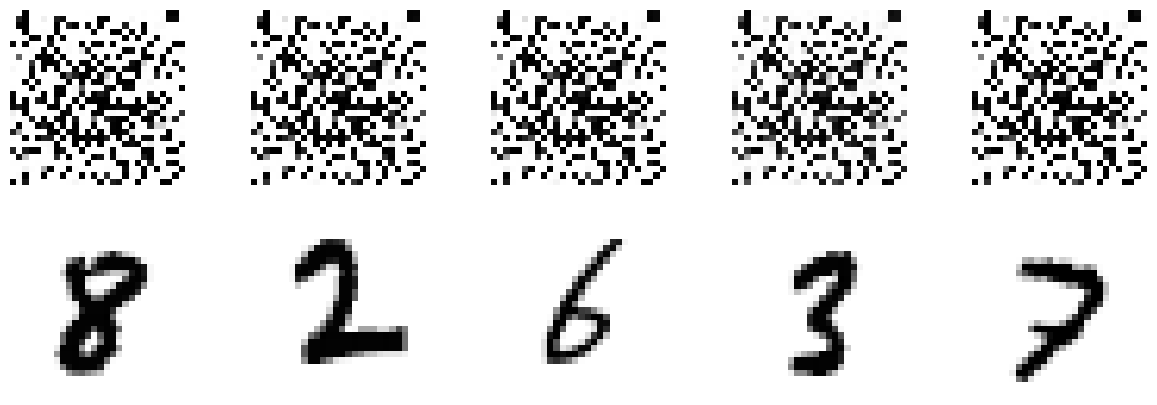

1/1 [==============================] - 0s 41ms/step
D loss:  2.3682860136032104
D accuracy:  1.0
G loss:  2.3692593574523926


1/1 [==============================] - 0s 14ms/step
D loss:  2.368281602859497
D accuracy:  1.0
G loss:  2.3692681789398193




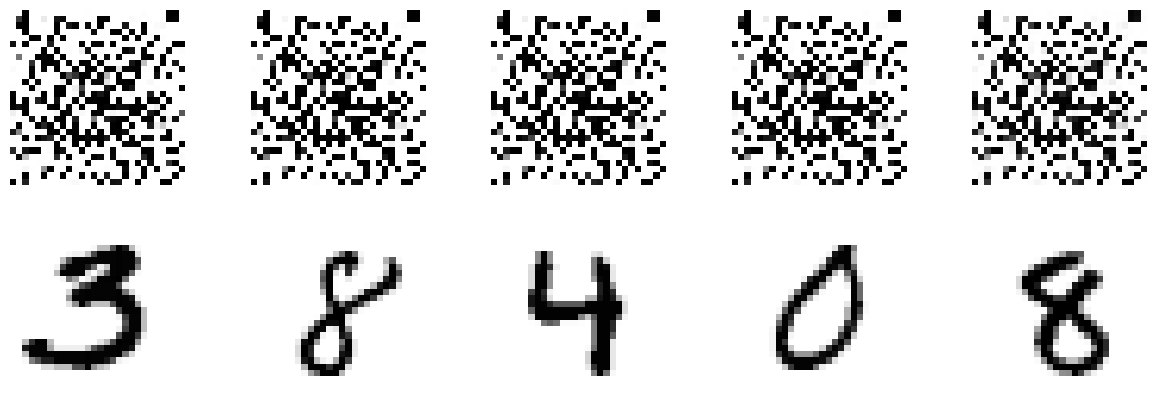

1/1 [==============================] - 0s 19ms/step
D loss:  2.3682745695114136
D accuracy:  1.0
G loss:  2.3692479133605957


1/1 [==============================] - 0s 22ms/step
D loss:  2.368278741836548
D accuracy:  1.0
G loss:  2.369277000427246




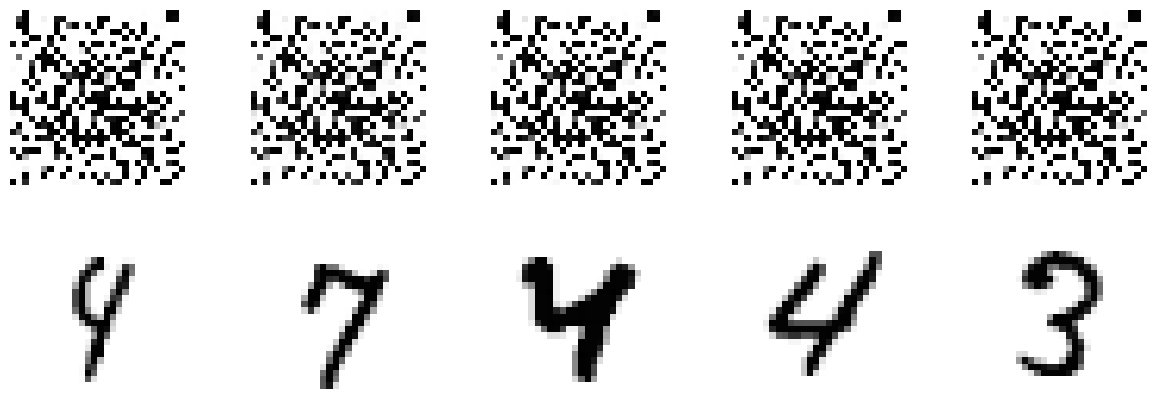

1/1 [==============================] - 0s 16ms/step
D loss:  2.3682714700698853
D accuracy:  1.0
G loss:  2.369255304336548


1/1 [==============================] - 0s 15ms/step
D loss:  2.3682756423950195
D accuracy:  1.0
G loss:  2.3692736625671387




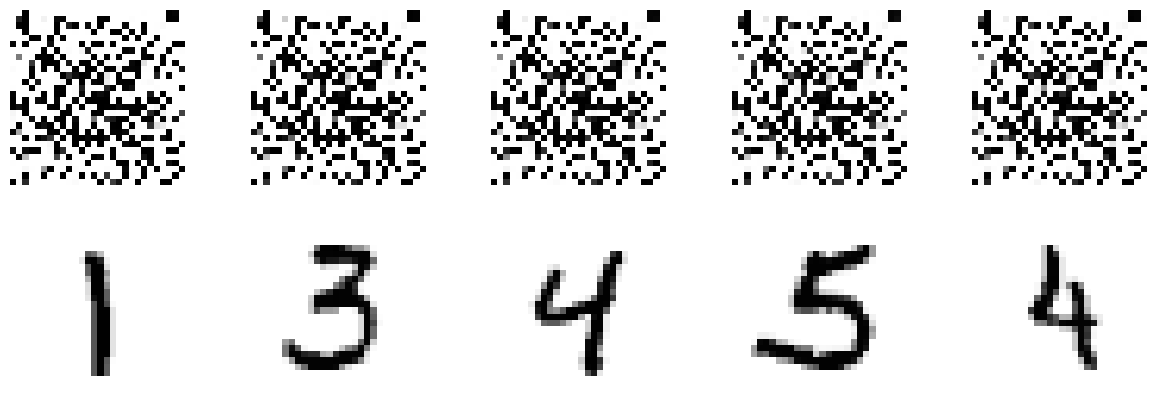

1/1 [==============================] - 0s 25ms/step
D loss:  2.368338704109192
D accuracy:  1.0
G loss:  2.369337320327759


1/1 [==============================] - 0s 31ms/step
D loss:  2.3683385848999023
D accuracy:  1.0
G loss:  2.369347333908081




KeyboardInterrupt: ignored

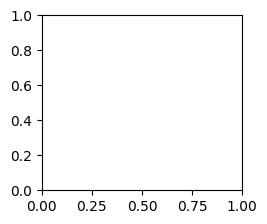

In [ ]:
train(X_train, generator, discriminator, combined, epochs=10, batch_size=32, sample_interval=100)

##Fin del entrenamiento

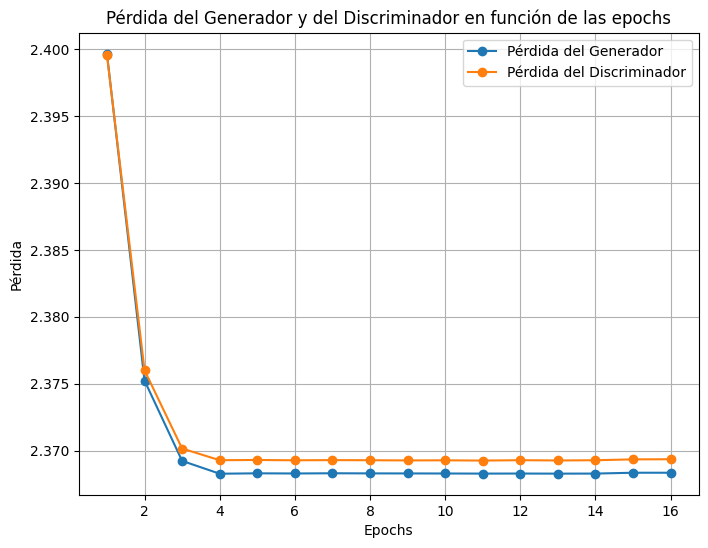

In [ ]:
import matplotlib.pyplot as plt

# Crear una lista de epochs
epochs = list(range(1, len(generator_loss_2[3:]) + 1))  # Suponemos que el número de epochs es el mismo para ambas pérdidas

# Graficar la pérdida del generador y del discriminador en función de las epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, generator_loss_2[3:], label='Pérdida del Generador', marker='o', linestyle='-')
plt.plot(epochs, discriminator_loss_2[3:], label='Pérdida del Discriminador', marker='o', linestyle='-')
plt.title('Pérdida del Generador y del Discriminador en función de las epochs')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

El error que se produce ahora es un gradient vanishing

#Segundo Regularizador:

In [22]:
#Lista que acumula la funcion de perdida para luego plotearla
generator_loss_3 =[]
discriminator_loss_3= []

In [23]:
def create_discriminator():
  input = Input(shape=(28,28,1))

  x = Flatten()(input)

  x = Dense(512, activation = 'relu',kernel_regularizer=l1(0.01))(x)
  x = Dense(128, activation = 'relu',kernel_regularizer=l1(0.01))(x)
  x = Dense(64, activation = 'relu',kernel_regularizer=l1(0.01))(x)

  output = Dense(1,activation = 'sigmoid')(x)


  discriminator = Model(input,output)
  return discriminator

###---------------###########-------------------###

###---------------###########-------------------###
discriminator = create_discriminator()
plot_model(discriminator, show_shapes=True,show_layer_names=False)
###---------------###########-------------------###
discriminator.compile(loss = 'binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

z = Input(shape=(100,))
img = generator(z)
validity = discriminator(img)

combined = Model(z,validity)
combined.compile(loss='binary_crossentropy')
###---------------###########-------------------###
def  train(X_train, generator, discriminator, combined,epochs, batch_size=32,sample_interval=100):
  valid = np.ones((batch_size,1))
  fake = np.ones((batch_size,1))

  for epoch in range(epochs):
    print("Epoch: ", epoch)

    for batch in range(int(len(X_train)/batch_size)):
      #Entreno del discriminador
      noise = np.random.normal(0,1,(batch_size,100))
      gen_imgs = generator.predict(noise)
      imgs = X_train[batch*batch_size : (batch+1)*batch_size]

      d_loss_real = discriminator.train_on_batch(imgs, valid)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, valid)

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      #Entreno del generador
      noise = np.random.normal(0,1,(batch_size,100))
      g_loss = combined.train_on_batch(noise,valid)

      if batch%50 == 0:
        print("D loss: ",d_loss[0])
        generator_loss_3.append(d_loss[0])
        print("D accuracy: ",d_loss[1])
        print("G loss: ",g_loss)
        discriminator_loss_3.append(g_loss)
        print("\n")

      if batch%sample_interval==0:
        sample_images(gen_imgs,imgs)


###---------------###########-------------------###
def sample_images(gen_imgs,imgs):
  plt.rcParams['figure.figsize'] = [15,5]
  fig,axs = plt.subplots(2,5)
  for i in range(5):
    axs[0,i].imshow(gen_imgs[i,:,:,0],cmap="Greys")
    axs[0,i].axis("off")

  for i in range(5):
    axs[1,i].imshow(imgs[i,:,:,0],cmap="Greys")
    axs[1,i].axis("off")
  plt.show()
  plt.close()
###---------------###########-------------------###


###Entrenamiento

Epoch:  0
1/1 [==============================] - 0s 15ms/step
D loss:  169.9168472290039
D accuracy:  0.84375
G loss:  153.79425048828125




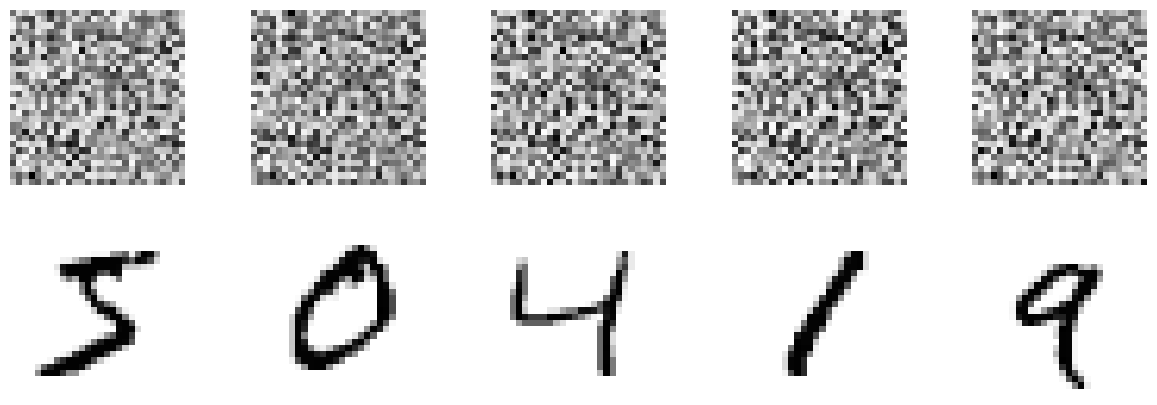

1/1 [==============================] - 0s 15ms/step
D loss:  3.715981125831604
D accuracy:  1.0
G loss:  3.6584060192108154


1/1 [==============================] - 0s 35ms/step
D loss:  2.4871485233306885
D accuracy:  1.0
G loss:  2.48150897026062




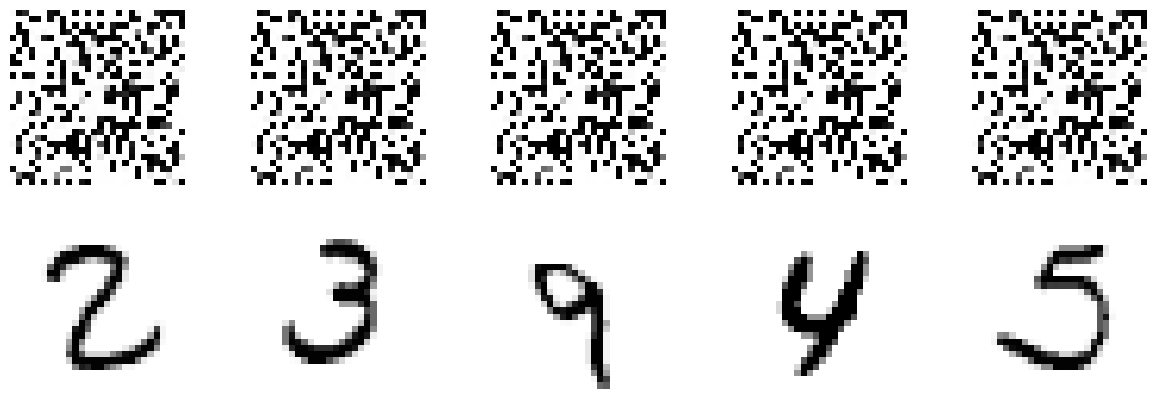

1/1 [==============================] - 0s 16ms/step
D loss:  2.422933340072632
D accuracy:  1.0
G loss:  2.418867588043213


1/1 [==============================] - 0s 17ms/step
D loss:  2.38497531414032
D accuracy:  1.0
G loss:  2.3827295303344727




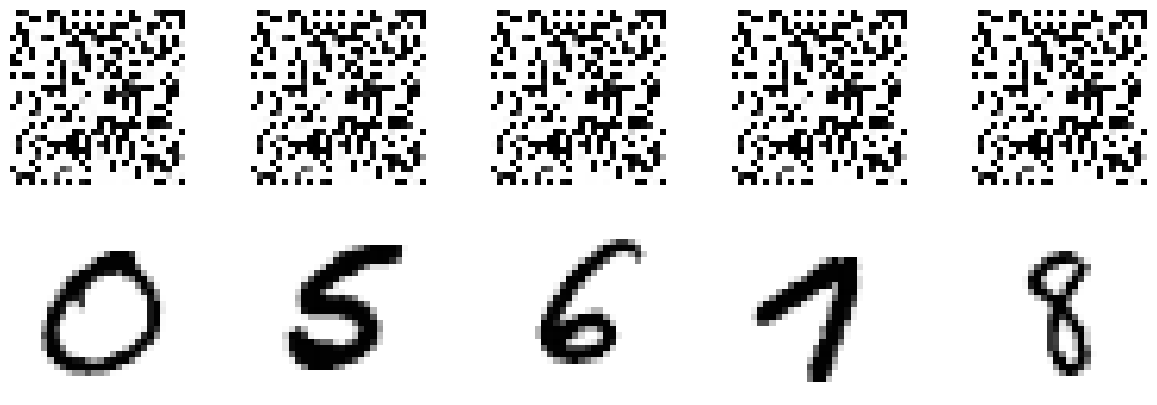

1/1 [==============================] - 0s 16ms/step
D loss:  2.3710802793502808
D accuracy:  1.0
G loss:  2.3692846298217773


1/1 [==============================] - 0s 23ms/step
D loss:  2.367775321006775
D accuracy:  1.0
G loss:  2.366168975830078




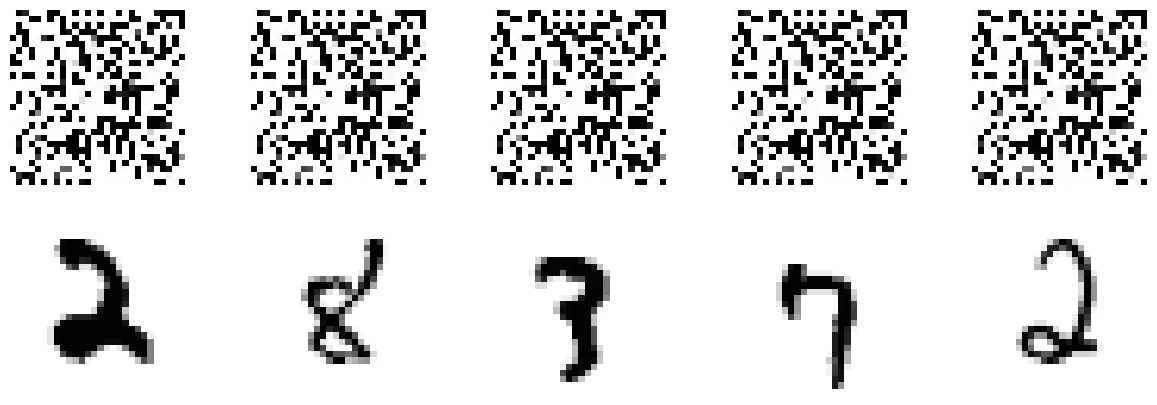

1/1 [==============================] - 0s 14ms/step
D loss:  2.367798924446106
D accuracy:  1.0
G loss:  2.3662631511688232


1/1 [==============================] - 0s 17ms/step
D loss:  2.3678863048553467
D accuracy:  1.0
G loss:  2.3664464950561523




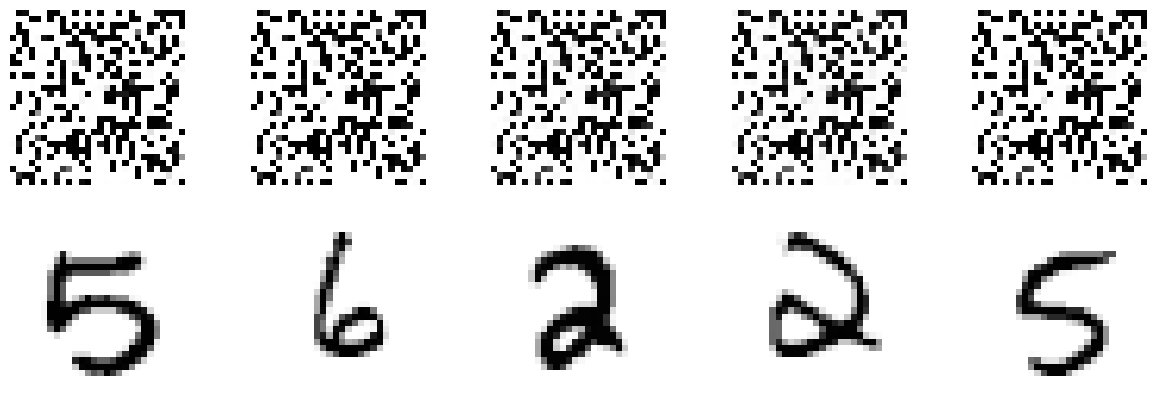

1/1 [==============================] - 0s 24ms/step
D loss:  2.367889881134033
D accuracy:  1.0
G loss:  2.366442918777466


1/1 [==============================] - 0s 15ms/step
D loss:  2.3678864240646362
D accuracy:  1.0
G loss:  2.366469144821167




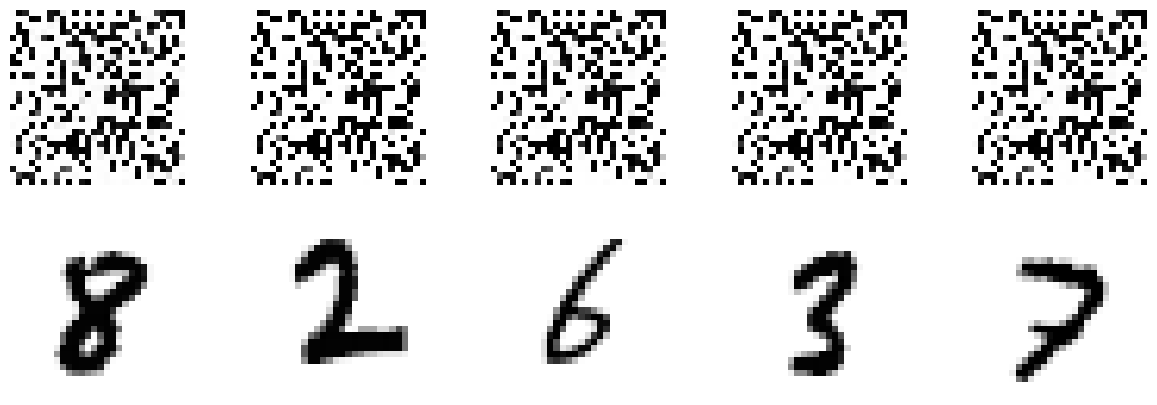

1/1 [==============================] - 0s 16ms/step
D loss:  2.3679152727127075
D accuracy:  1.0
G loss:  2.366511344909668


1/1 [==============================] - 0s 17ms/step
D loss:  2.367918372154236
D accuracy:  1.0
G loss:  2.3665153980255127




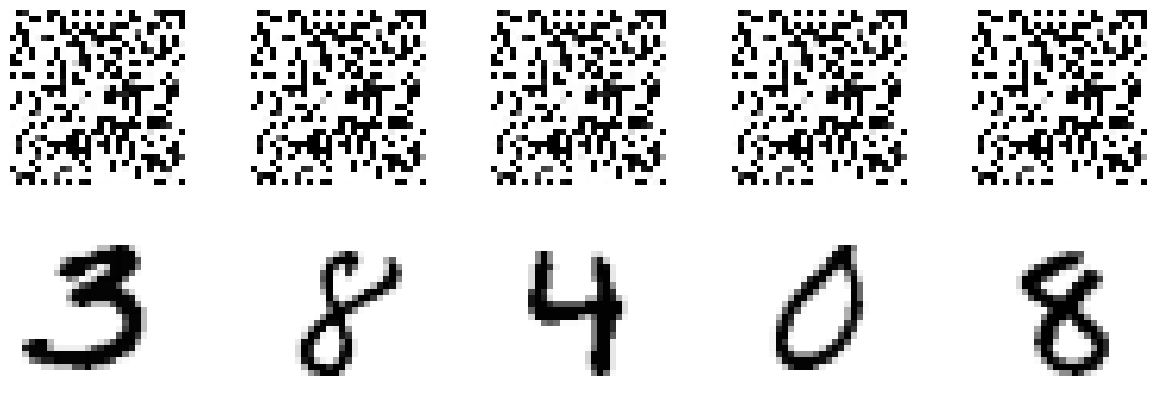

1/1 [==============================] - 0s 26ms/step
D loss:  2.367948889732361
D accuracy:  1.0
G loss:  2.366546869277954


1/1 [==============================] - 0s 15ms/step
D loss:  2.3679566383361816
D accuracy:  1.0
G loss:  2.366586446762085




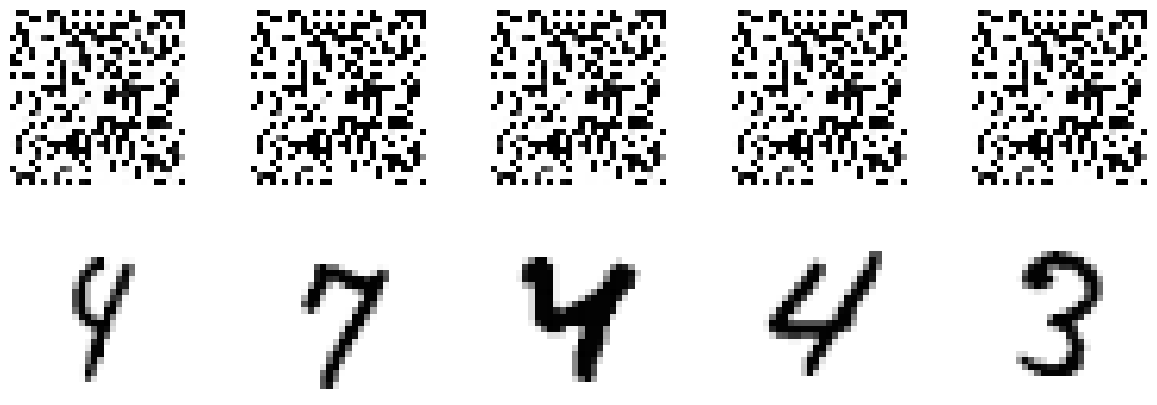

1/1 [==============================] - 0s 18ms/step
D loss:  2.3679535388946533
D accuracy:  1.0
G loss:  2.3665478229522705


1/1 [==============================] - 0s 22ms/step
D loss:  2.367953062057495
D accuracy:  1.0
G loss:  2.3665764331817627




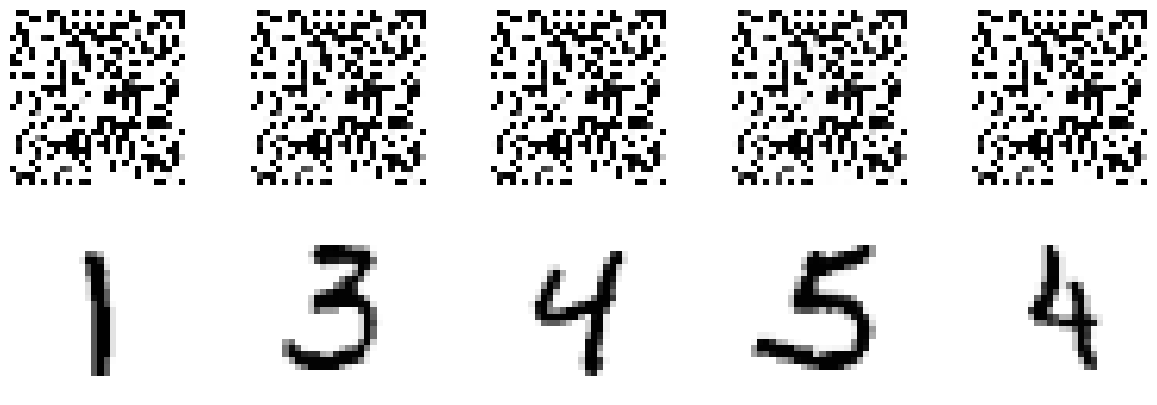

1/1 [==============================] - 0s 17ms/step
D loss:  2.367977499961853
D accuracy:  1.0
G loss:  2.366589307785034


1/1 [==============================] - 0s 17ms/step


KeyboardInterrupt: ignored

In [24]:
train(X_train, generator, discriminator, combined, epochs=10, batch_size=32, sample_interval=100)

###Fin del entrenamiento

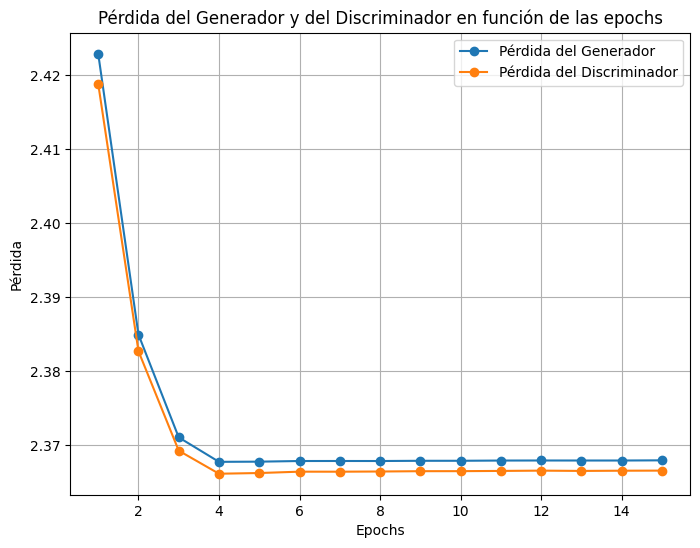

In [26]:
import matplotlib.pyplot as plt

# Crear una lista de epochs
epochs = list(range(1, len(generator_loss_3[3:]) + 1))  # Suponemos que el número de epochs es el mismo para ambas pérdidas

# Graficar la pérdida del generador y del discriminador en función de las epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, generator_loss_3[3:], label='Pérdida del Generador', marker='o', linestyle='-')
plt.plot(epochs, discriminator_loss_3[3:], label='Pérdida del Discriminador', marker='o', linestyle='-')
plt.title('Pérdida del Generador y del Discriminador en función de las epochs')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

Commo se puede ver se ha conseguido crear una red generadora muy competente que consigue evolucionar de manera correcta debido a que el problema inicial de una red discriminadora potente se ha erradicado a traves de los distintos usos de regularizaciones en las redes discriminadoras

# Tercer regularizador

In [ ]:
#Lista que acumula la funcion de perdida para luego plotearla
generator_loss_3 =[]
discriminator_loss_3= []

In [ ]:
def create_discriminator():
  input = Input(shape=(28,28,1))

  x = Flatten()(input)

  x = Dense(512, activation = 'relu',kernel_regularizer=l1(0.01))(x)
  x = Dense(128, activation = 'relu',kernel_regularizer=l1(0.01))(x)
  x = Dense(64, activation = 'relu',kernel_regularizer=l1(0.01))(x)

  output = Dense(1,activation = 'sigmoid')(x)


  discriminator = Model(input,output)
  return discriminator

###---------------###########-------------------###

###---------------###########-------------------###
discriminator = create_discriminator()
plot_model(discriminator, show_shapes=True,show_layer_names=False)
###---------------###########-------------------###
discriminator.compile(loss = 'binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

z = Input(shape=(100,))
img = generator(z)
validity = discriminator(img)

combined = Model(z,validity)
combined.compile(loss='binary_crossentropy')
###---------------###########-------------------###
def  train(X_train, generator, discriminator, combined,epochs, batch_size=32,sample_interval=100):
  valid = np.ones((batch_size,1))
  fake = np.ones((batch_size,1))

  for epoch in range(epochs):
    print("Epoch: ", epoch)

    for batch in range(int(len(X_train)/batch_size)):
      #Entreno del discriminador
      noise = np.random.normal(0,1,(batch_size,100))
      gen_imgs = generator.predict(noise)
      imgs = X_train[batch*batch_size : (batch+1)*batch_size]

      d_loss_real = discriminator.train_on_batch(imgs, valid)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, valid)

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      #Entreno del generador
      noise = np.random.normal(0,1,(batch_size,100))
      g_loss = combined.train_on_batch(noise,valid)

      if batch%50 == 0:
        print("D loss: ",d_loss[0])
        generator_loss_3.append(d_loss[0])
        print("D accuracy: ",d_loss[1])
        print("G loss: ",g_loss)
        discriminator_loss_3.append(g_loss)
        print("\n")

      if batch%sample_interval==0:
        sample_images(gen_imgs,imgs)


###---------------###########-------------------###
def sample_images(gen_imgs,imgs):
  plt.rcParams['figure.figsize'] = [15,5]
  fig,axs = plt.subplots(2,5)
  for i in range(5):
    axs[0,i].imshow(gen_imgs[i,:,:,0],cmap="Greys")
    axs[0,i].axis("off")

  for i in range(5):
    axs[1,i].imshow(imgs[i,:,:,0],cmap="Greys")
    axs[1,i].axis("off")
  plt.show()
  plt.close()
###---------------###########-------------------###


### Entrenamiento

In [ ]:
train(X_train, generator, discriminator, combined, epochs=10, batch_size=32, sample_interval=100)

### Fin del entrenamiento


In [ ]:
import matplotlib.pyplot as plt

# Crear una lista de epochs
epochs = list(range(1, len(generator_loss_3[3:]) + 1))  # Suponemos que el número de epochs es el mismo para ambas pérdidas

# Graficar la pérdida del generador y del discriminador en función de las epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, generator_loss_3[3:], label='Pérdida del Generador', marker='o', linestyle='-')
plt.plot(epochs, discriminator_loss_3[3:], label='Pérdida del Discriminador', marker='o', linestyle='-')
plt.title('Pérdida del Generador y del Discriminador en función de las epochs')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()